<a href="https://colab.research.google.com/github/bcaffo/ds4ph-bme/blob/master/notebooks/GAN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise, we'll build a generalized adversarial network to generate cryptopunks. You might have heard of the recent NFT (non-fungible token) craze. Cryptopunks are example NFT assets that one can buy. As of this writing, the cheapest Cryptopunk is worth over $40,000 dollars. The punks each have attributes, like a mustache or hairstyle. We'll train a conv net to classify punks by attributes. First we'll need to download all of the cryptopunks, which are in a giant single image file. Then separate them into the individual punks. (There's probably an easier way to do this, but this wasn't that hard.) Then we'll build a tensorflow model of the punks.

We're following along from this example https://www.tensorflow.org/tutorials/generative/dcgan


In [22]:
import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tqdm.notebook import tqdm


Import the image of all of the cryptopunks.

In [2]:
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")

('cryptoPunksAll.jpg', <http.client.HTTPMessage at 0x7f7e9ed250d0>)

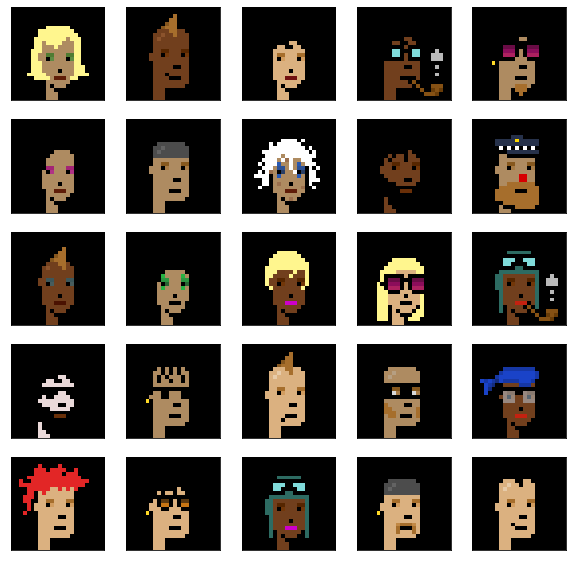

In [3]:
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)
finalArray = np.empty((10000, 24, 24, 3))
## Split the image into the individual punk images
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,:,:,:] = imgArray[a:b,c:d,:] /255

plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(finalArray[i,:,:,:])

In [4]:
finalArray.shape

(10000, 24, 24, 3)

Let's create a generator. It takes in a random normal vector and spits out an image. The goal is to get it to spit out cryptopunk-like images by training its weights.

In [5]:
generator = tf.keras.Sequential()
generator.add(layers.InputLayer(input_shape = (1728)))
generator.add(layers.Dense(1728, activation = 'relu'))
generator.add(layers.Reshape(target_shape = (24, 24, 3)))

Let's run some noise through the generator and see how it's doing now.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 24, 24, 3)


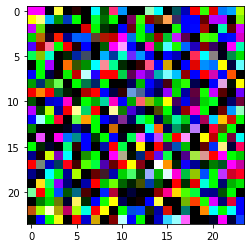

In [6]:
noise = tf.random.normal([1, 1728])
testImg = generator(noise)
print(testImg.shape)
plt.imshow(testImg[0, :, :, :])

Not so good. Now let's define a discriminator. The goal of the discriminator is to detect whether or not the image is fake or real. It's what's used to test our generator.  The "adversary".

In [7]:
discriminator = tf.keras.Sequential()
discriminator.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (24, 24, 3)))
discriminator.add(layers.Conv2D(64, (3, 3), activation='relu'))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(64, activation='relu'))
discriminator.add(layers.Dense(1))

Let's test the discriminator out on the image we generated just to see that it works. Obviously, without having been trained, it's not a very good one yet.

In [8]:
print(discriminator(testImg))

tf.Tensor([[-0.00832324]], shape=(1, 1), dtype=float32)


Define our discriminator loss. This just assigns a one to all of the real images and a 0 for all of the fake images then calculates cross entropy.

In [9]:
# This is only necessary so we don't have to type so much
# define cross entropy loss
ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = ce(tf.ones_like(real_output), real_output)
    fake_loss = ce(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Now define our generator loss. This is just going to look at the images that it generated and see who well it did with respect to the discriminator.

In [10]:
def generator_loss(fake_output):
    return ce(tf.ones_like(fake_output), fake_output)

Now let's add the optimizers

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Define some constants.

In [26]:
EPOCHS = 500
N = finalArray.shape[0]
noise_dim = 1728

In [29]:
for epoch in tqdm(range(EPOCHS)):
  noise = tf.random.normal([N, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(finalArray, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

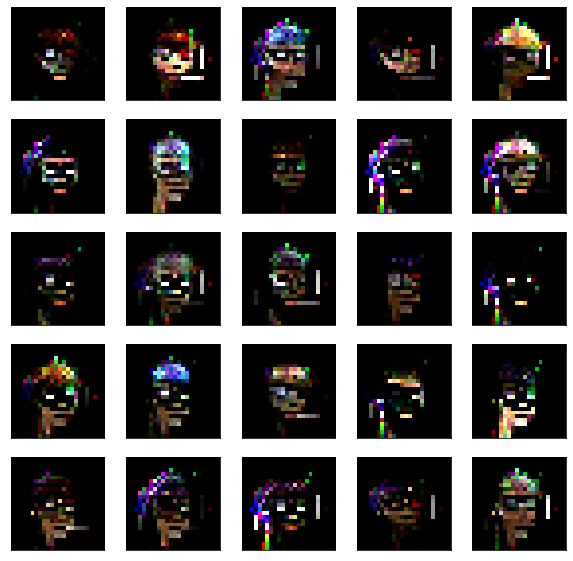

In [30]:
plt.figure(figsize=(10,10))
toPlot = generated_images.numpy()
toPlot.astype(np.uint8)
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(toPlot[i,:,:,:])